In [1]:
import numpy as np 
import tensorflow as tf 
from tensorflow.keras.models import Model ,Sequential
from tensorflow.keras.layers import Dense,Conv2D,Dropout,MaxPool2D,BatchNormalization,Input,\
Flatten,GlobalAveragePooling2D
import math 
import warnings 
from tensorflow.keras import regularizers
warnings.filterwarnings("ignore")
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import VGG16 , EfficientNetB7
import cv2 as cv
from collections import defaultdict
import os 
import shutil
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix , classification_report
import pandas as pd
import seaborn as sns 

## Data preparation :

## VGG16 :

In [2]:
vgg = EfficientNetB7(weights="imagenet",include_top=False ,input_shape=(72,72,3),pooling="avg")

258080768/258076736 [==============================] - 1s 0us/step


In [3]:
def build_vgg() : 
 
 for layer in vgg.layers[-6:] :
    layer.trainable = True
 x = vgg.output
 #x = Flatten()(x)
 x = BatchNormalization()(x)
 x = Dropout(0.25)(x)
 predictions = Dense(512,activation="relu",kernel_regularizer=regularizers.l2(0.0001))(x)
 predictions= BatchNormalization()(predictions)
 #predictions = Dropout(0.25)(predictions)
 #predictions = Dense(256,activation="relu")(predictions)
 #predictions = BatchNormalization()(predictions)
 predictions = Dropout(0.25)(predictions)
 predictions = Dense(128,activation="relu",kernel_regularizer=regularizers.l2(0.0001))(predictions)
 #predictions = BatchNormalization()(predictions)
 #predictions = Dropout(0.25)(predictions)
 #predictions = Dense(64,activation="relu")(predictions)
 #predictions = BatchNormalization()(predictions)
 #predictions = Dropout(0.25)(predictions)
 #predictions = Dense(32,activation="relu")(predictions)
 predictions = BatchNormalization()(predictions)
 predictions = Dropout(0.25)(predictions)
 predictions = Dense(7,activation="softmax")(predictions)
 model_VGG = Model(vgg.input,predictions)
 
 model_VGG.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),loss=\
                 [tf.keras.losses.CategoricalCrossentropy()],metrics=["accuracy"])
 return model_VGG

In [4]:
val_generator = ImageDataGenerator(rescale=1/255)

tr_generator = ImageDataGenerator(rescale = 1/255,
                                  zoom_range=0.3,
                                  shear_range=0.3,
                                  horizontal_flip=True,
                                  rotation_range=30,
                                  fill_mode="nearest")

In [5]:
val_data = val_generator.flow_from_directory("../input/fer2013/test",
                                             batch_size= 64,
                                             target_size=(72,72),
                                             color_mode="rgb",
                                             interpolation="nearest")
tr_data = tr_generator.flow_from_directory("../input/fer2013/train",
                                          batch_size= 64,
                                          target_size=(72,72),
                                          color_mode="rgb",
                                          interpolation="nearest")

Found 7178 images belonging to 7 classes.
Found 28709 images belonging to 7 classes.


In [6]:
model_VGG = build_vgg()
vgg_step_1 = ModelCheckpoint("vgg_step1.h5",monitor="val_accuracy",mode="max",save_best_only=True,\
                            save_weights_only=True,verbose=1)

In [7]:
model_VGG.fit(tr_data,validation_data=val_data,epochs=100,callbacks=[vgg_step_1])

Epoch 1/100
449/449 [==============================] - 279s 545ms/step - loss: 2.7300 - accuracy: 0.1705 - val_loss: 2.3371 - val_accuracy: 0.1609

Epoch 00001: val_accuracy improved from -inf to 0.16091, saving model to vgg_step1.h5
Epoch 2/100
449/449 [==============================] - 177s 394ms/step - loss: 2.3393 - accuracy: 0.2489 - val_loss: 1.9661 - val_accuracy: 0.3271

Epoch 00002: val_accuracy improved from 0.16091 to 0.32711, saving model to vgg_step1.h5
Epoch 3/100
449/449 [==============================] - 176s 392ms/step - loss: 2.0614 - accuracy: 0.3088 - val_loss: 1.8167 - val_accuracy: 0.3508

Epoch 00003: val_accuracy improved from 0.32711 to 0.35079, saving model to vgg_step1.h5
Epoch 4/100
449/449 [==============================] - 176s 392ms/step - loss: 1.8409 - accuracy: 0.3633 - val_loss: 1.6038 - val_accuracy: 0.4400

Epoch 00004: val_accuracy improved from 0.35079 to 0.43996, saving model to vgg_step1.h5
Epoch 5/100
449/449 [==============================] - 

In [8]:
val_data = val_generator.flow_from_directory("../input/fer2013/test",
                                             shuffle = False,
                                             batch_size= 64,
                                             target_size=(72,72),
                                             color_mode="rgb",
                                             interpolation="nearest")

Found 7178 images belonging to 7 classes.


In [9]:
y_true = val_data.classes

In [10]:
effnet_model = build_vgg()
effnet_model.load_weights("vgg_step1.h5")

In [11]:
y_pred = effnet_model.predict(val_data)

In [12]:
y_pred = np.argmax(y_pred,axis=1)

In [13]:
classes = list(val_data.class_indices.keys())

<AxesSubplot:>

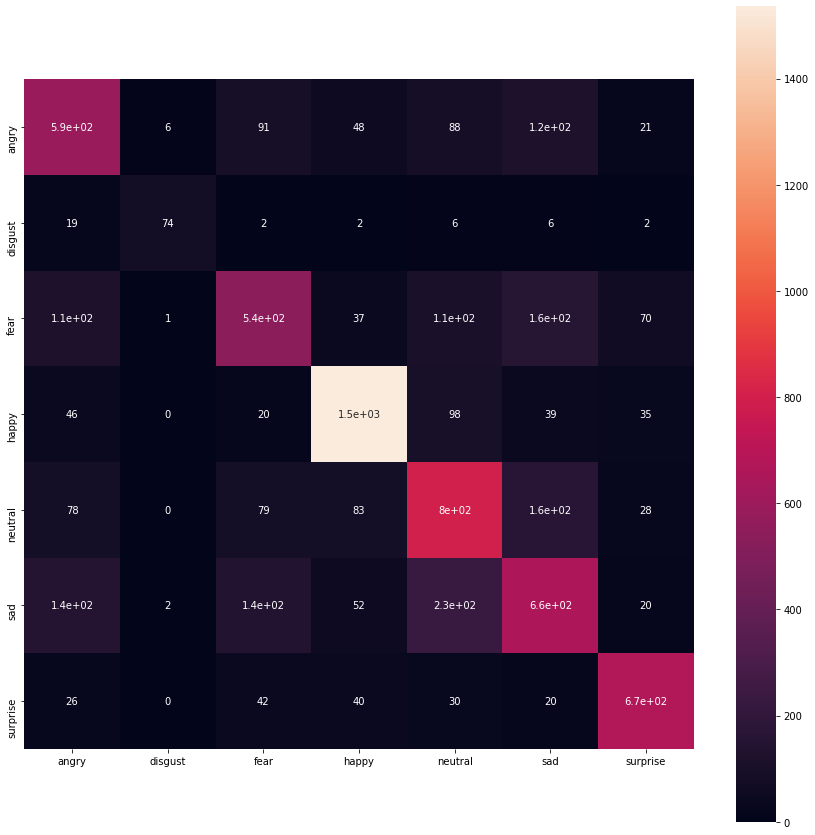

In [14]:
fig = plt.figure(figsize = (15,15))
cf = pd.DataFrame(confusion_matrix(y_true,y_pred),columns=classes,index=classes)
sns.heatmap(cf,annot=True,square=True)

In [15]:
print(classification_report(y_true,y_pred,target_names=classes))

              precision    recall  f1-score   support

       angry       0.58      0.61      0.60       958
     disgust       0.89      0.67      0.76       111
        fear       0.59      0.52      0.55      1024
       happy       0.85      0.87      0.86      1774
     neutral       0.59      0.65      0.62      1233
         sad       0.57      0.53      0.55      1247
    surprise       0.79      0.81      0.80       831

    accuracy                           0.68      7178
   macro avg       0.69      0.67      0.68      7178
weighted avg       0.68      0.68      0.68      7178

